In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

from darkgreybox.model import TiTe

2020-10-13 11:20:41,343 darkgreybox  INFO     Logging enabled...


In [2]:
# the duration of a record
rec_duration = 1 # hour

In [3]:
train_df = pd.read_csv('./data/demo_data.csv', index_col=0, parse_dates=True)

input_X = train_df[['Ph', 'Ta', 'Th']]
input_y = train_df['Ti']

input_X['Ti0'] = input_y
input_X['Th0'] = input_y
input_X['Te0'] = input_y - 2 

print(f'Input X shape: {input_X.shape}, input y shape: {input_y.shape}')

Input X shape: (792, 6), input y shape: (792,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, test_size=5 / 33, shuffle=False)

print(f'Train: X shape: {X_train.shape}, y shape: {y_train.shape}')
print(f'Test: X shape: {X_test.shape}, y shape: {y_test.shape}')

Train: X shape: (672, 6), y shape: (672,)
Test: X shape: (120, 6), y shape: (120,)


In [6]:
train_params = {
    'Ti0': {'value': y_train.iloc[0], 'vary': False},
    'Te0': {'value': y_train.iloc[0], 'vary': True},
    'Ci': {'value': 1},
    'Ce': {'value': 1},
    'Rie': {'value': 1},
    'Rea': {'value': 1},
}

In [21]:
model = TiTe(params=train_params, rec_duration=rec_duration) \
            .fit(X=X_train, y=y_train, method='leastsq')

In [22]:
model.result.params

name,value,initial value,min,max,vary
Ti0,18.1375000,18.1375,-inf,inf,False
Te0,18.8031823,18.1375,-inf,inf,True
Ci,1.00652117,1,-inf,inf,True
Ce,0.95851117,1,-inf,inf,True
Rie,1.04365938,1,-inf,inf,True
Rea,0.98705055,1,-inf,inf,True


In [23]:
train_results = model.predict(X=X_train)

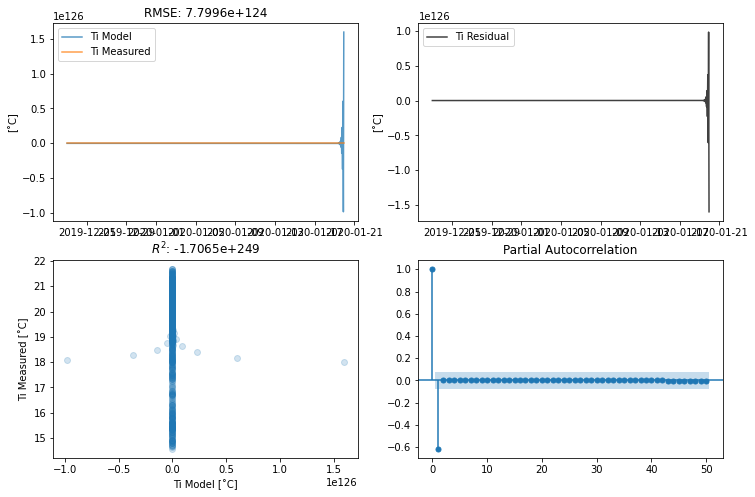

In [25]:
rmse = mean_squared_error(y_train, train_results.Z) ** 0.5
r2 = r2_score(y_train, train_results.Z)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(y_train.index, train_results.Z, label='Ti Model', alpha=0.75)
ax[0, 0].plot(y_train, label='Ti Measured', alpha=0.75)
ax[0, 0].legend()
ax[0, 0].set_ylabel('[˚C]')
ax[0, 0].set_title(f'RMSE: {rmse:.4e}')

ax[1, 0].scatter(train_results.Z, y_train, alpha=0.2)
ax[1, 0].set_xlabel('Ti Model [˚C]')
ax[1, 0].set_ylabel('Ti Measured [˚C]')
ax[1, 0].set_title(f'$R^2$: {r2:.4e}')

ax[0, 1].plot(y_train.index, y_train - train_results.Z, label='Ti Residual', color='black', alpha=0.75)
ax[0, 1].legend()
ax[0, 1].set_ylabel('[˚C]')

plot_pacf(y_train - train_results.Z, ax=ax[1, 1], lags=50);


In [26]:
test_results = model.predict(X=X_test, ic_params={'Ti0': y_test.iloc[0], 'Te0': train_results.Te[-1]})

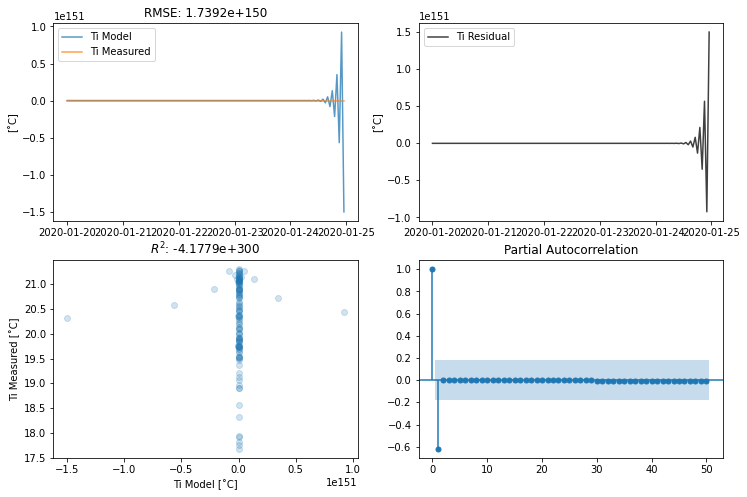

In [28]:
rmse = mean_squared_error(y_test, test_results.Z) ** 0.5
r2 = r2_score(y_test, test_results.Z)

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].plot(y_test.index, test_results.Z, label='Ti Model', alpha=0.75)
ax[0, 0].plot(y_test, label='Ti Measured', alpha=0.75)
ax[0, 0].legend()
ax[0, 0].set_ylabel('[˚C]')
ax[0, 0].set_title(f'RMSE: {rmse:.4e}')

ax[1, 0].scatter(test_results.Z, y_test, alpha=0.2)
ax[1, 0].set_xlabel('Ti Model [˚C]')
ax[1, 0].set_ylabel('Ti Measured [˚C]')
ax[1, 0].set_title(f'$R^2$: {r2:.4e}')

ax[0, 1].plot(y_test.index, y_test - test_results.Z, label='Ti Residual', color='black', alpha=0.75)
ax[0, 1].legend()
ax[0, 1].set_ylabel('[˚C]')

plot_pacf(y_test - test_results.Z, ax=ax[1, 1], lags=50);
